---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

class UnsupervisedLearning:
    def __init__(self, data):
        """
        Initialize the UnsupervisedLearning class with the dataset.
        
        Parameters:
            data (pd.DataFrame): Input dataset for analysis.
        """
        self.data = data
        self.pca_result = None
        self.tsne_result = None
        self.clusters = {}
    def preprocess_data(self, impute_strategy='mean', drop_na_threshold=0.5, normalize=True, scaler_type='standard'):
        """
        Preprocess the data to ensure it's suitable for unsupervised learning:
        - Drop columns with excessive missing values.
        - Impute missing values for numeric columns.
        - Convert non-numeric columns to numeric using encoding.
        - Normalize numeric columns if required.

        Parameters:
            impute_strategy (str): Strategy for imputing missing values ('mean', 'median', 'most_frequent').
            drop_na_threshold (float): Threshold for dropping columns with missing values (default: 0.5).
            normalize (bool): Whether to normalize numeric columns (default: True).
            scaler_type (str): Type of scaler to use ('standard' for StandardScaler, 'minmax' for MinMaxScaler).
        """
        # Drop columns with excessive missing values
        missing_ratio = self.data.isna().mean()
        cols_to_drop = missing_ratio[missing_ratio > drop_na_threshold].index
        self.data.drop(columns=cols_to_drop, inplace=True)

        # Separate numeric and non-numeric columns
        numeric_cols = self.data.select_dtypes(include=['number']).columns
        non_numeric_cols = self.data.select_dtypes(exclude=['number']).columns

        # Handle non-numeric columns
        if len(non_numeric_cols) > 0:
            self.data = pd.get_dummies(self.data, columns=non_numeric_cols, drop_first=True)

        # Impute missing values in numeric columns
        imputer = SimpleImputer(strategy=impute_strategy)
        self.data[numeric_cols] = imputer.fit_transform(self.data[numeric_cols])

        # Normalize numeric columns if required
        if normalize:
            scaler = StandardScaler() if scaler_type == 'standard' else MinMaxScaler()
            self.data[numeric_cols] = scaler.fit_transform(self.data[numeric_cols])

    def apply_pca(self, n_components=None):
        """
        Apply PCA to the dataset and visualize the explained variance ratio.

        Parameters:
            n_components (int, optional): Number of components for PCA. 
                                          If None, all components are considered.
        """
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(self.data)
        self.pca_result = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
        
        # Explained variance plot
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
        plt.title('Cumulative Explained Variance by PCA Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid()
        plt.show()

    def visualize_pca(self):
        """Visualize PCA-reduced data if 2 or 3 components are present."""
        if self.pca_result is None:
            print("Please run `apply_pca()` first.")
            return
        
        if self.pca_result.shape[1] >= 2:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=self.pca_result, x='PC1', y='PC2', alpha=0.7)
            plt.title('PCA Visualization (First Two Components)')
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.grid()
            plt.show()
        else:
            print("PCA visualization requires at least 2 components.")

    def apply_tsne(self, perplexity=30, n_components=2, random_state=42):
        """
        Apply t-SNE to the dataset and visualize the results.

        Parameters:
            perplexity (int): Perplexity parameter for t-SNE.
            n_components (int): Number of dimensions for t-SNE.
            random_state (int): Random state for reproducibility.
        """
        tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
        tsne_result = tsne.fit_transform(self.data)
        self.tsne_result = pd.DataFrame(tsne_result, columns=[f'Dim{i+1}' for i in range(n_components)])
        
        # t-SNE plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.tsne_result['Dim1'], y=self.tsne_result['Dim2'], alpha=0.7)
        plt.title(f't-SNE Visualization (Perplexity={perplexity})')
        plt.xlabel('Dim1')
        plt.ylabel('Dim2')
        plt.grid()
        plt.show()

    def kmeans_clustering(self, n_clusters):
        """
        Apply K-Means clustering and visualize clusters.

        Parameters:
            n_clusters (int): Number of clusters for K-Means.
        """
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(self.data)
        self.clusters['kmeans'] = labels

        silhouette = silhouette_score(self.data, labels)
        print(f"K-Means Silhouette Score: {silhouette:.4f}")
        
        # Cluster visualization
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.pca_result['PC1'], y=self.pca_result['PC2'], hue=labels, palette='tab10', alpha=0.7)
        plt.title('K-Means Clustering (PCA Reduced Data)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='Cluster')
        plt.grid()
        plt.show()
    
    def kmeans_clustering_tsne(self, n_clusters, palette='tab10'):
        """
        Apply K-Means clustering and visualize clusters.

        Parameters:
            n_clusters (int): Number of clusters for K-Means.
        """
        if not hasattr(self, 'tsne_result') or self.tsne_result.empty:
            raise ValueError("t-SNE results not found. Run apply_tsne() before clustering.")
    
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(self.data)
        self.clusters['kmeans'] = labels

        # Calculate silhouette score
        silhouette = silhouette_score(self.data, labels)
        print(f"K-Means Silhouette Score: {silhouette:.4f}")

        # Visualization
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x=self.tsne_result['Dim1'],
            y=self.tsne_result['Dim2'],
            hue=labels,
            palette=palette,
            alpha=0.7,
            legend='full'
        )
        plt.title('K-Means Clustering (t-SNE Reduced Data)')
        plt.xlabel('Dim1')
        plt.ylabel('Dim2')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()
        plt.show()

        return silhouette

    def dbscan_clustering(self, eps, min_samples):
        """
        Apply DBSCAN clustering and visualize clusters.

        Parameters:
            eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood.
            min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.
        """
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(self.data)
        self.clusters['dbscan'] = labels

        silhouette = silhouette_score(self.data, labels) if len(set(labels)) > 1 else "N/A"
        print(f"DBSCAN Silhouette Score: {silhouette}")
        
        # Cluster visualization
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.pca_result['PC1'], y=self.pca_result['PC2'], hue=labels, palette='tab10', alpha=0.7)
        plt.title('DBSCAN Clustering (PCA Reduced Data)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='Cluster')
        plt.grid()
        plt.show()

    def hierarchical_clustering(self, method='ward', distance_threshold=0):
        """
        Apply Hierarchical clustering and visualize dendrogram.

        Parameters:
            method (str): Linkage criterion (e.g., 'ward', 'complete', 'average').
            distance_threshold (float): Threshold for cutting the dendrogram.
        """
        linkage_matrix = linkage(self.data, method=method)
        plt.figure(figsize=(12, 8))
        dendrogram(linkage_matrix, truncate_mode='level', p=5)
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Sample Index')
        plt.ylabel('Distance')
        plt.show()

        if distance_threshold > 0:
            labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
            self.clusters['hierarchical'] = labels
            silhouette = silhouette_score(self.data, labels)
            print(f"Hierarchical Clustering Silhouette Score: {silhouette:.4f}")

In [98]:
data = pd.read_csv('../../data/processed-data/food_merged.csv')

category_columns = [
    'tons_donations', 'tons_industrial_uses', 'tons_animal_feed',
    'tons_anaerobic_digestion', 'tons_composting', 'tons_not_harvested',
    'tons_incineration', 'tons_land_application', 'tons_landfill',
    'tons_sewer', 'tons_dumping'
]

data['total'] = data[category_columns].sum(axis=1)

# Calculate the percentage of total for each column
percentage_df = data[category_columns].div(data['total'], axis=0)

# Find the column with the maximum percentage for each row
data['disposal_method'] = percentage_df.idxmax(axis=1)
data['disposal_method'] = data['disposal_method'].str.replace('tons_', '', regex=False)

# Drop the total column if no longer needed
data.drop(columns=['total'], inplace=True)

data['donation_bin'] = np.where(data['tons_donations'] > 0, 1, 0)
print(data.shape)

(7084, 42)


/var/folders/sj/4yswlk7n08x8jfcfnyw2vkqw0000gn/T/ipykernel_93714/718609560.py:16: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data['disposal_method'] = percentage_df.idxmax(axis=1)


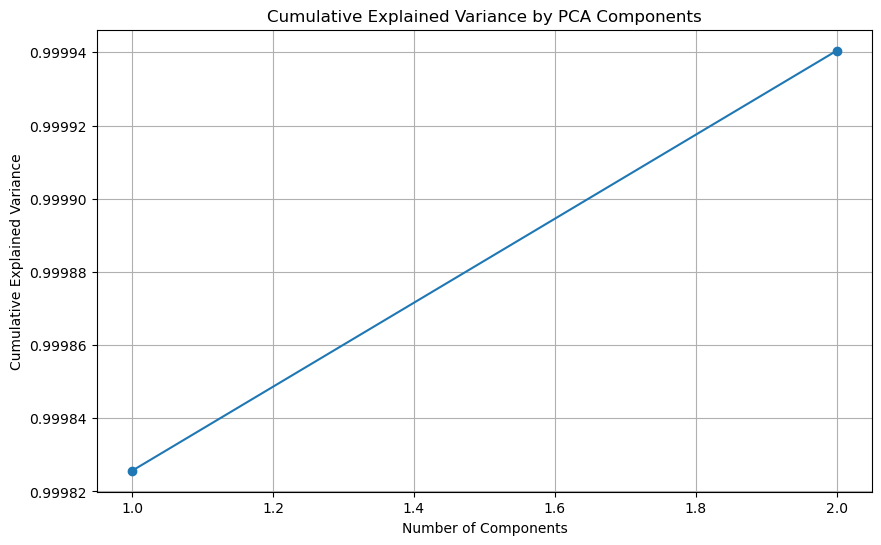

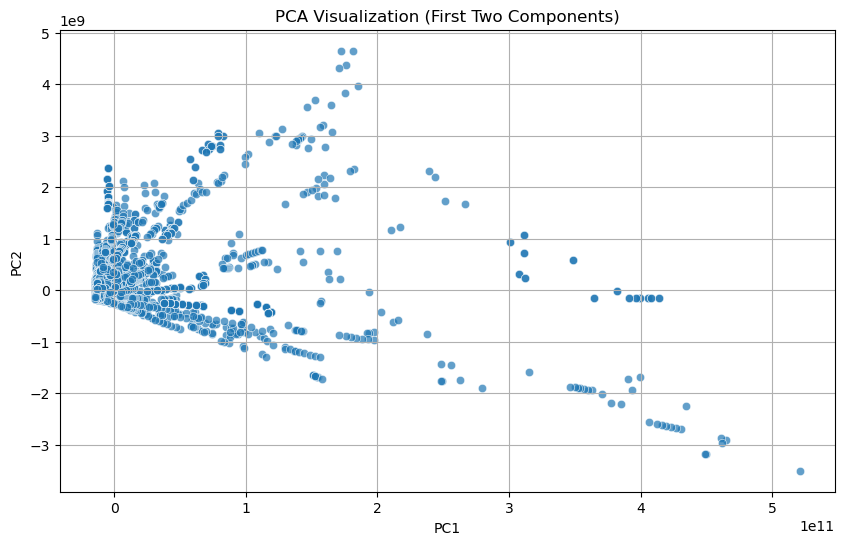

In [ ]:
unsupervised_learner = UnsupervisedLearning(data)
unsupervised_learner.preprocess_data(impute_strategy='median', normalize=True, scaler_type='minmax')
# Apply PCA
unsupervised_learner.apply_pca(n_components=2)
unsupervised_learner.visualize_pca()

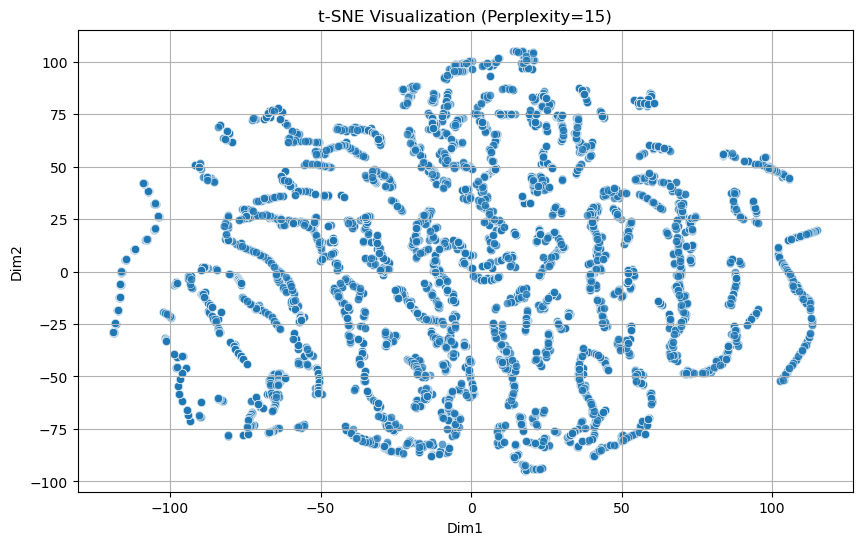

In [100]:
unsupervised_learner.apply_tsne(perplexity=15)

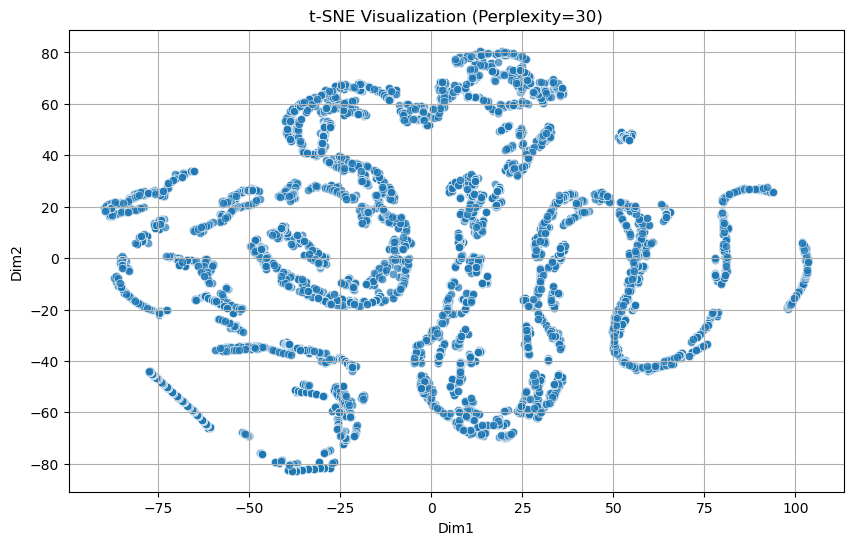

In [101]:
unsupervised_learner.apply_tsne(perplexity=30)

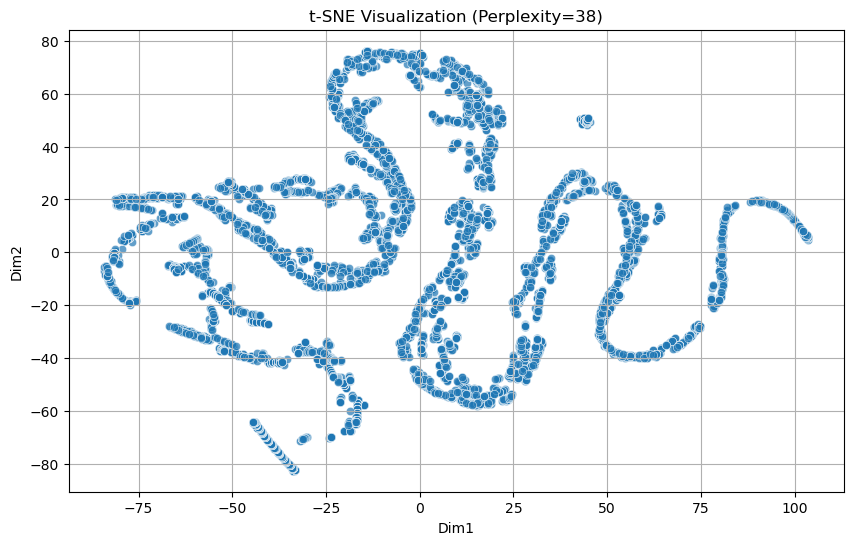

In [102]:

# Apply t-SNE
unsupervised_learner.apply_tsne(perplexity=38)



K-Means Silhouette Score: 0.8908


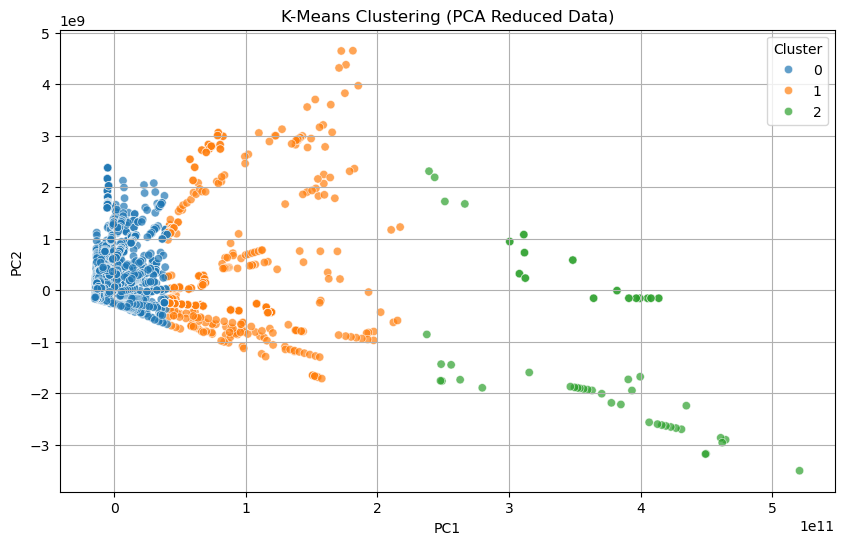

In [103]:
unsupervised_learner.kmeans_clustering(n_clusters=3)

K-Means Silhouette Score: 0.8908


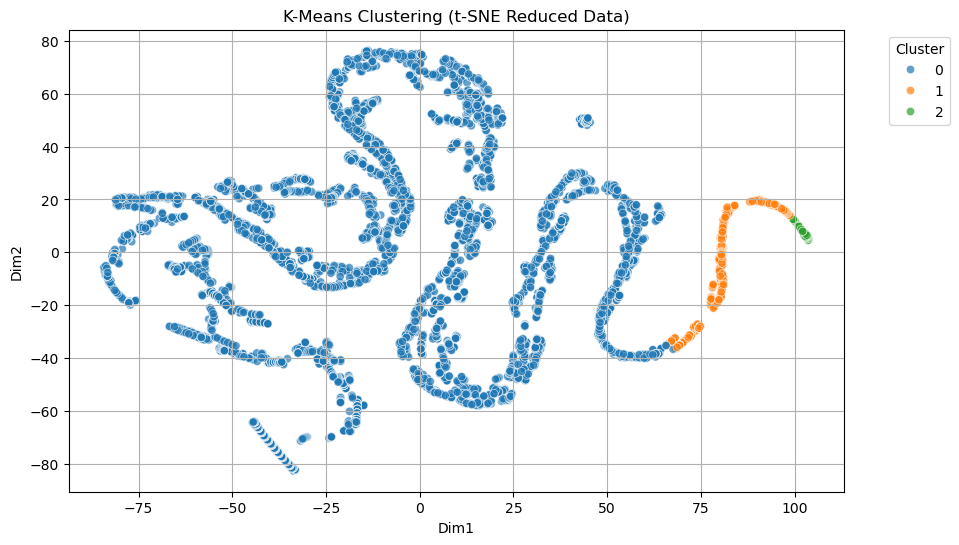

0.8908280420716205

In [104]:
unsupervised_learner.kmeans_clustering_tsne(n_clusters=3)

DBSCAN Silhouette Score: 0.5664975908757899


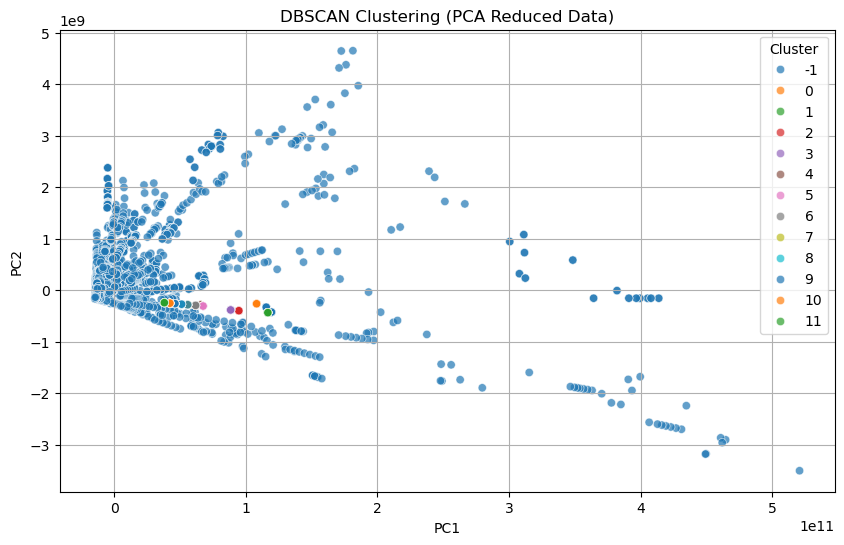

In [105]:
unsupervised_learner.dbscan_clustering(eps=0.5, min_samples=5)

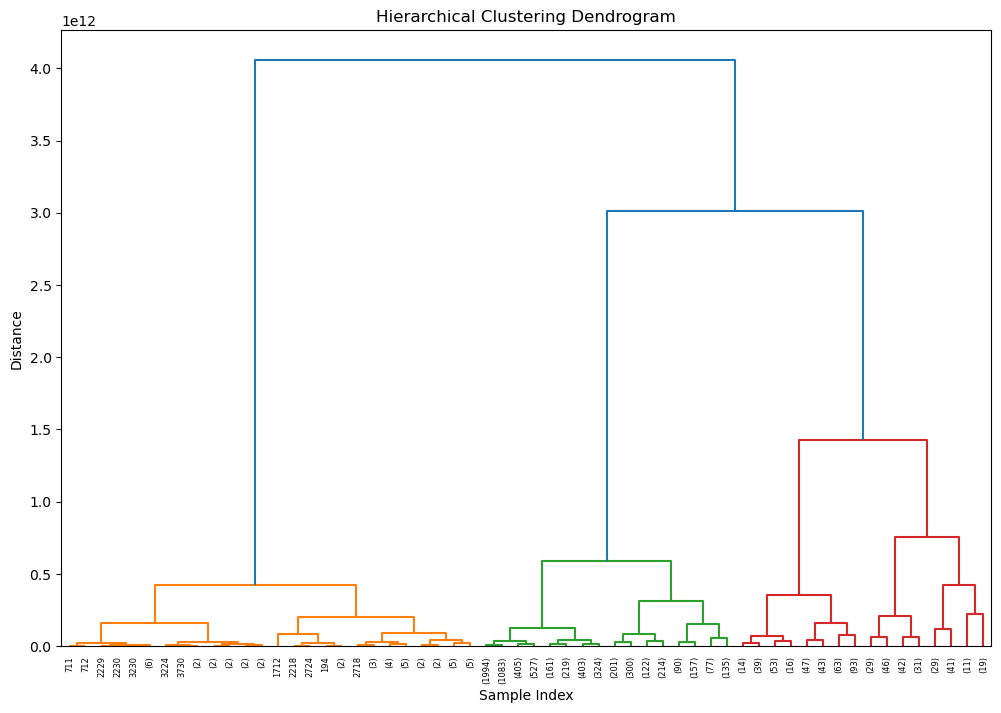

Hierarchical Clustering Silhouette Score: 0.0484


In [106]:
unsupervised_learner.hierarchical_clustering(method='ward', distance_threshold=10)